In [ ]:
import sys
import os
import itertools

import numpy as np
import torch as tr
from CSWSEM import *

In [142]:
import os
import numpy as np
import torch as tr
import pandas as pd

from CSWSEM import *
from matplotlib import pyplot as plt

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
## input params
learn_rate = 0.01
alfa = 0.01
lmda = 100000
stsize = 25

In [147]:
condL = ['blocked','interleaved']

exp_kwargs={
    'n_train':160,
    'n_test':40
}

sem_kwargs={
    'nosplit':False,
    'stsize':stsize,
    'lmda':lmda,
    'alfa':alfa,
    'learn_rate':learn_rate,
    'seed':seed,
}


dataL = []
for seed in np.arange(3):
  for cond in condL:
    print(seed,cond)
    np.random.seed(seed)
    tr.manual_seed(seed)
    # setup
    exp_kwargs['condition'] = cond
    task = CSWTask()
    sem = SEM(**sem_kwargs)
    exp,curr = task.generate_experiment(**exp_kwargs)
    # run
    sem_data = sem.forward_exp(exp,curr)
    sem.data.record_exp('condition',exp_kwargs['condition'])
    dataL.append(pd.DataFrame(sem_data))
    ehat = np.array([tdata['event_hat'] for tdata in sem_data])
data = pd.concat(dataL)

0 blocked
0 interleaved
1 blocked
1 interleaved
2 blocked
2 interleaved


In [145]:
""" 
concat sem_data from multiple 
seeds and conditions
"""
# def format_dataL(dataL):
df = pd.concat(dataL)
df = df.astype({'loss':float})
df.loc[:,'acc1'] = 1-df.loss
#   return df
# format_dataL(dataL)

In [148]:
task.embed_mat.shape

task.exp_int

array([[0, 1, 4, 6, 8, 9],
       [0, 2, 4, 5, 8, 9],
       [0, 1, 3, 5, 7, 9],
       ...,
       [0, 2, 3, 6, 7, 9],
       [0, 2, 4, 5, 8, 9],
       [0, 2, 4, 5, 8, 9]])

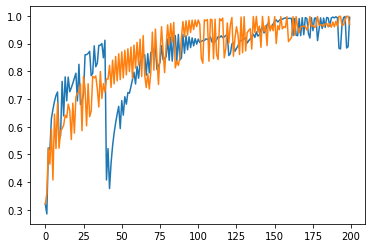

In [87]:
df.groupby(['condition','seed','trial']).mean()
for cond in ['blocked','interleaved']:
  cond_df = df[df.loc[:,'condition'] == cond]
  M = cond_df.groupby('trial').mean()
  plt.plot(M.loc[:,'acc1'])

In [123]:
""" move into task
"""
from sklearn.linear_model import LogisticRegression
clf_class = LogisticRegression
clf_kwargs = dict(C=10.0, multi_class='multinomial', solver='lbfgs')
decoder = clf_class(**clf_kwargs)
decoder.fit(task.embed_mat,
            np.arange(task.embed_mat.shape[0])
           )
decoder.predict_proba # nsamples,nfeatures

# verb_decoding_clf

In [149]:
e = ehat.reshape(-1,10)
print(ehat.shape,e.shape)
ehat_proba = decoder.predict_proba(e).reshape(200,5,11)
ehat_proba.shape


(200, 5, 10) (1000, 10)


(200, 5, 11)

In [174]:
## translate_2afc
print(ehat_proba.shape)
layers = [3,4]
scenes = [(5,6),(7,8)]

for lay,stup in zip(layers,scenes):
  # get relevant probas
  layer_proba = ehat_proba[:,lay,stup]
  # normalize
  layer_proba /= layer_proba.sum(1,keepdims=1)
  
layer_proba
# layer_proba /= layer_proba.sum(1)
# print(layer_proba.shape)


# # layer3
# # ehat_proba[:,4,(7,8)]
# layer_proba

(200, 5, 11)


array([[0.26984378, 0.73015622],
       [0.53755878, 0.46244122],
       [0.29997966, 0.70002034],
       [0.25802726, 0.74197274],
       [0.37215826, 0.62784174],
       [0.29622654, 0.70377346],
       [0.4292515 , 0.5707485 ],
       [0.51903276, 0.48096724],
       [0.47411049, 0.52588951],
       [0.47976129, 0.52023871],
       [0.51512246, 0.48487754],
       [0.44568833, 0.55431167],
       [0.51632925, 0.48367075],
       [0.33841811, 0.66158189],
       [0.48235435, 0.51764565],
       [0.43123874, 0.56876126],
       [0.47223335, 0.52776665],
       [0.44323977, 0.55676023],
       [0.47535028, 0.52464972],
       [0.47431748, 0.52568252],
       [0.49095889, 0.50904111],
       [0.38971551, 0.61028449],
       [0.51580747, 0.48419253],
       [0.44345293, 0.55654707],
       [0.54642365, 0.45357635],
       [0.48727793, 0.51272207],
       [0.57966059, 0.42033941],
       [0.51638844, 0.48361156],
       [0.61292881, 0.38707119],
       [0.510196  , 0.489804  ],
       [0.